## Algorithm

[Psuedocode for all 3 helper EEGLAB programs joint probability.](https://github.com/NeuroDataDesign/orange-panda/blob/master/notes/bad_chan_detect/eeglab-bad-electrode.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Fix random seed
initseed = 123456789
np.random.seed(initseed)
import StringIO
out = StringIO.StringIO()

In [2]:
a = np.ones((3,4,5,6))
a = np.rollaxis(a, 3)
print a.shape
a = np.rollaxis(a, 3)
print a.shape

(6, 3, 4, 5)
(5, 6, 3, 4)


In [172]:
# Write wrapper pop_jointprob
# inEEG = C x T x N, channels x trials x timepoints, numpy array
# elecrange = range of electrodes, list/numpy array
# locthresh = threshold for individual electrode inspection
# globthresh = threshold for entire dataset inspection
def pop_jointprob(inEEG, elecrange, locthresh, globthresh):
    # first, do localized individual electrode inspection
    jp, rej = jointprob(inEEG[elecrange,:,:], locthresh, 1)
    # now reshape data for global inspection
    globEEG = np.rollaxis(inEEG, 2)
    np.reshape(globEEG, (globEEG.shape[0], globEEG.shape[1] * globEEG.shape[2]))
    # run global inspection
    jpG, rejG = jointprob(globEEG[elecrange,:,:], globthresh, 1)
    return jp, rej, jpG, rejG

# Write next level wrapper, jointprob
# Joint prob can use different prob functions to get the distribution
# S = C x T x N, channels x trials x timepoints, numpy array
# OR
# S = N x (C x T), timepoints x (channels x trials), numpy array
# OR
# S = (N x C x T), straight vector of all timepoints, numpy array
# thresholds
# norm = choose normalization: 0 = none, 1 = normalize entropy, 2 = 20% trim
# thresh = threshold
def jointprob(S, thresh, normalize, discret = 1000):
    # get num chans and trials and time
    channels = 0
    trials = 0
    timepts = 0
    if S.ndim == 1 or S.ndim == 2:
        timepts = S.shape[0]
    elif S.ndim == 3:
        channels = S.shape[0]
        trials = S.shape[1]
        timepts = S.shape[2]
        S_flattened = np.reshape(S, (channels, trials * timepts))
    else:
        print "Bad dimensions"
        return
    
    # Get Joint Probs
    jp = np.zeros((channels, timepts))
    for c in range(channels):
        prob, dist = realproba(S_flattened, discret)
        for t in range(trials):
            tmp = prob[t * timepts, (t + 1) * timepts - 1]
            jp[c,t] = -np.sum(log(tmp))
    
    # Normalize data
    if normalize:
        tmpjp = jp
        if normalize == 2:
            tmpjp = sort(jp);
            totrim = round(len(tmpjp) * 0.1)
            tmpjp = tmpjp[totrim : -totrim]
        if S.ndim == 2:
            jp = (jp - np.mean(tmpjp)) / np.std(tmpjp)
        elif S.ndim == 3:
            centered = jp - np.mean(tmpjp, 2) * np.ones(jp.shape[2])
            stddev = std(tmpjp, 2, ddof = 1) * np.ones(jp.shape[2])
            jp = np.divide(centered, divide)

    # Reject bad elecs
    rej = abs(jp) > thresh
    
    return jp, rej

# Histogram binning implementation
# D = T x N, D = data Trials, Number of timepts
# b = bins, default 1000
def realproba(D, b = 1000):
    SIZE = D.shape[0] * D.shape[1]
    P = np.zeros(b)
    P_dist = np.zeros(b)
    minimum = np.min(D)
    maximum = np.max(D)
    D = np.floor((D - minimum)/(maximum - minimum) * (b - 1)).astype(int)
    D_flat = np.ndarray.flatten(D)
#     print D
    for i in range(SIZE):
        P_dist[D_flat[i]] = P_dist[D_flat[i]] + 1
    P = P_dist[D] / SIZE
    P_dist = P_dist / SIZE
    if P_dist.ndim < P.ndim:
        P_dist = np.expand_dims(P_dist, P.ndim - P_dist.ndim)
    return P, P_dist.T

This will run well with a small range of data.

For test data will just use our dataset (for now).

Also, here will import the actual MATLAB algorithm.

In [4]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [143]:
a = np.array([[2, 2, 2, 3], [2, 2, 2, 3], [2, 2, 2, 3], [2, 2, 2, 3]])
e, f = realproba(a, 6)
c, d = eng.realproba(eng.eval(str(a)), 6.0, stdout = out, nargout = 2)
print np.array_equal(e, c)
print e
print c

test_split = str(a).split()
for i in range(len(test_split)):
    if test_split[i][-1:] == "]":
        test_split[i] = test_split[i] + ";"
    elif test_split[i] != "[[" and test_split[i] != "[":
        test_split[i] = test_split[i] + ","
newstr = ' '.join(test_split)
print newstr
c, d = eng.realproba(eng.eval(str(a)), 6.0, stdout = out, nargout = 2)
print np.array_equal(e, c)
print e
print c

True
[[ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]]
[[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25]]
[[2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]];
True
[[ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]]
[[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25]]


***
## Simulated Data

### To check realproba

- Make random 1D and 2D arrays:
    - 10 4x4 2D arrays, range of values 0-10, 15-25 bins
    - 10 30 1D arrays, range of values 0-50, 55-65 bins
    - 10 30 x 30 2D arrays, range of values 0-50, 55-65 bins

## Realproba Simulated Data First

In [102]:
def probdata(case):
    bins = 0
    array = []
    if case == 0:
        bins = np.floor(np.random.uniform(15, 25))
        array = np.random.uniform(0, 10, size = (4, 4))
    elif case == 1:
        bins = np.floor(np.random.uniform(50, 60))
        array = np.random.uniform(0, 50, size = (1, 30))
    else:
        bins = np.floor(np.random.uniform(50, 60))
        array = np.random.uniform(0, 50, size = (30,30))
    return array, bins
    
array = np.random.uniform(0, 50, size = (30, 30))
print array.ndim

2


Real proba data will just look like random noise

In [110]:
def eval_proba(arr1, arr2):
    return np.array_equal(arr1, arr2)

In [145]:
test = probdata(2)
test_split = str(test[0]).split()
for i in range(len(test_split)):
    if test_split[i][-1:] == "]":
        test_split[i] = test_split[i] + ";"
    elif test_split[i] != "[[" and test_split[i] != "[":
        test_split[i] = test_split[i] + ","
newstr = ' '.join(test_split)
print newstr
        
out = StringIO.StringIO()
eng.realproba(
            eng.eval(newstr), float(test[1]), stdout = out, nargout = 2)
#print out.getvalue()

[[ 2.97774497e+01, 1.12014192e+01, 3.07053170e+01, 4.66749932e+01, 1.64284862e+01, 3.86281081e+01, 1.59410958e+01, 1.95885040e+01, 2.49662521e+01, 5.24618838e+00, 2.33730435e+00, 3.44332485e+00, 2.03425865e+00, 1.67736916e+01, 3.69759645e+01, 9.09792001e+00, 4.77412763e+01, 1.54654718e+01, 3.75194904e+01, 1.91781856e+00, 4.63719322e+01, 1.45648610e+01, 3.77816337e+01, 2.51026551e+01, 7.39983258e+00, 2.31948712e+01, 2.54115871e+01, 4.59066148e+01, 1.57528724e+01, 1.68759678e+01]; [ 1.53357427e+00, 3.78778444e+01, 3.74408087e+01, 8.54948289e+00, 8.06898064e+00, 3.44794987e+01, 4.26139311e+01, 1.76527657e+01, 5.89120915e+00, 3.09899200e+00, 4.60838068e+00, 1.88245707e+01, 2.37748761e-01, 1.82036037e+01, 3.02341159e+01, 2.97544501e+01, 4.24740858e+01, 1.79009726e+01, 2.46352112e+01, 4.83403579e+01, 2.26118218e+01, 3.15047788e+01, 2.46328599e+01, 3.65175500e+01, 2.16815641e+01, 2.37204735e+01, 3.88285875e+01, 3.83067178e+01, 3.14968647e+01, 4.76887176e+01]; [ 1.06484090e+01, 2.00224021e+00,

In [134]:
test_split = str(test[0]).split()
for i in range(len(test_split)):
    if test_split[i][-1:] == "]":
        test_split[i] = test_split[i] + ";"
    elif test_split[i] != "[[" and test_split[i] != "[":
        test_split[i] = test_split[i] + ","

print test_split[0]
print test_split[1]
print test_split[30]
print test_split[31]
print test_split[32]
print test_split[61]
print test_split[62]
print test_split[92]

newstr = ' '.join(test_split)
print newstr

[[
1.06587697e+01,
7.30453022e+00];
[
3.81254516e+01,
1.84912115e+01];
[
4.04723652e+01];
[[ 1.06587697e+01, 2.15339378e+01, 8.57652000e+00, 2.01131737e+01, 3.29682421e+01, 4.76038165e+01, 6.60591645e+00, 4.83050666e+01, 4.97977554e+01, 4.03506946e+01, 2.14789891e+01, 3.97160629e+01, 4.02427228e+01, 1.08497336e+01, 4.90638404e+01, 3.73257875e+01, 1.75835777e+01, 4.86761738e+00, 4.53952182e+01, 1.89972640e+01, 1.01840617e+01, 1.43213351e+00, 4.29819107e+01, 1.75956868e+01, 1.86248085e+01, 3.60373901e+01, 3.39169553e+01, 1.47109045e+01, 1.09043971e+01, 7.30453022e+00]; [ 3.81254516e+01, 2.20879810e+01, 4.82884280e+01, 4.75888634e+01, 3.93571639e+01, 1.63433115e+01, 1.16288337e+01, 4.33342490e+01, 3.84030321e+01, 3.09249115e+01, 1.51280923e+01, 4.91499151e+01, 4.13392963e+01, 4.21311446e+01, 2.01680220e+01, 4.39330965e+00, 3.36094759e+01, 3.18509694e+01, 4.12729299e+01, 1.50564509e+01, 4.72781230e+01, 2.86075725e+01, 2.57747769e+01, 1.40337989e+01, 2.29165186e+01, 3.75344297e+01, 1.245537

Real Proba Case 0


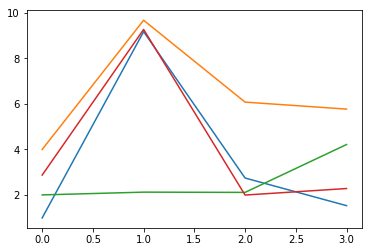

P equivalence: True
P_dist equivalence: True


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


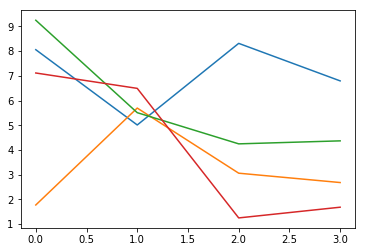

P equivalence: True
P_dist equivalence: True


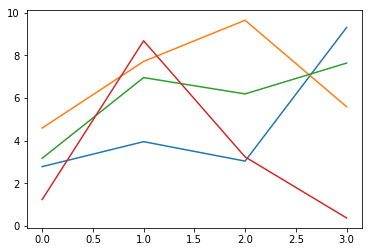

P equivalence: True
P_dist equivalence: True


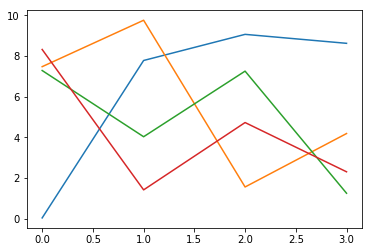

P equivalence: True
P_dist equivalence: True


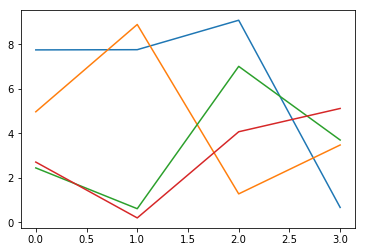

P equivalence: True
P_dist equivalence: True


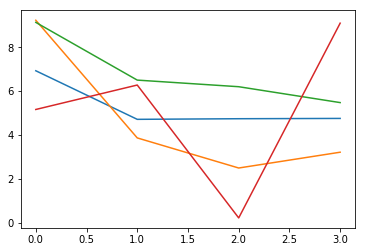

P equivalence: True
P_dist equivalence: True


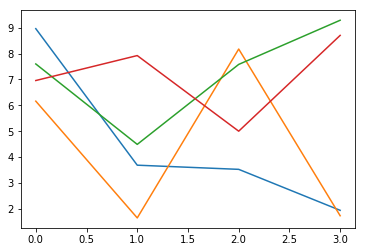

P equivalence: True
P_dist equivalence: True


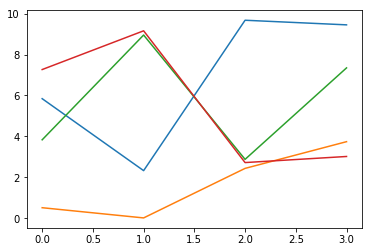

P equivalence: True
P_dist equivalence: True


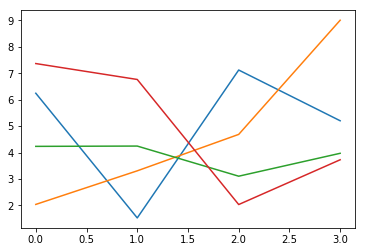

P equivalence: True
P_dist equivalence: True


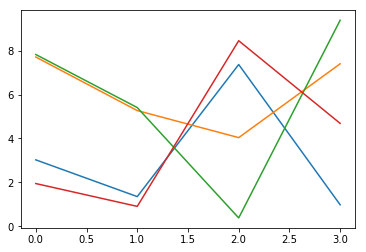

P equivalence: True
P_dist equivalence: True



Real Proba Case 1


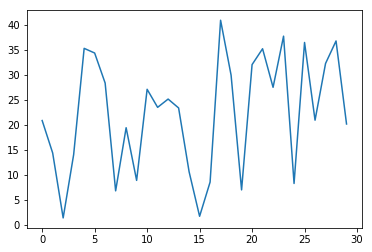

P equivalence: True
P_dist equivalence: True


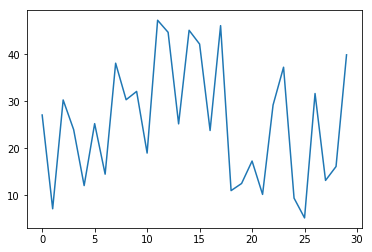

P equivalence: True
P_dist equivalence: True


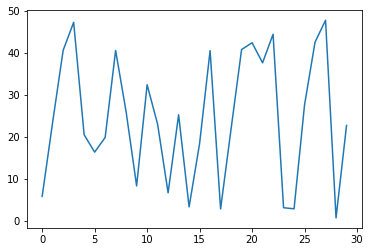

P equivalence: True
P_dist equivalence: True


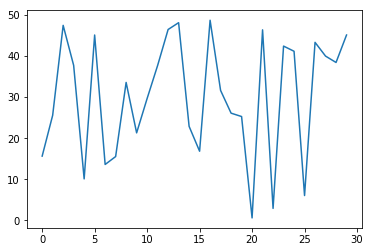

P equivalence: True
P_dist equivalence: True


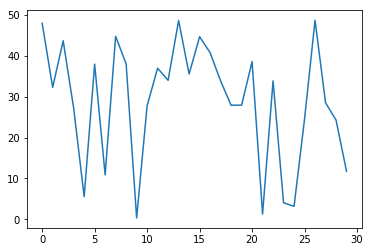

P equivalence: True
P_dist equivalence: True


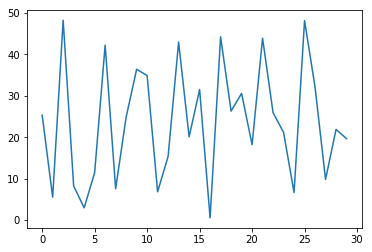

P equivalence: True
P_dist equivalence: True


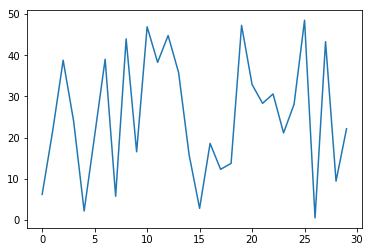

P equivalence: True
P_dist equivalence: True


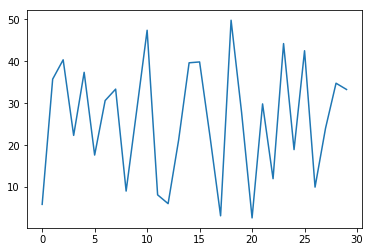

P equivalence: True
P_dist equivalence: True


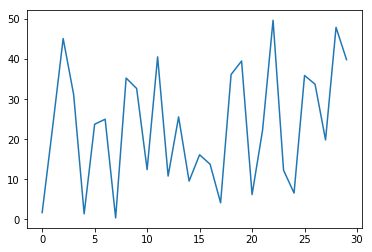

P equivalence: True
P_dist equivalence: True


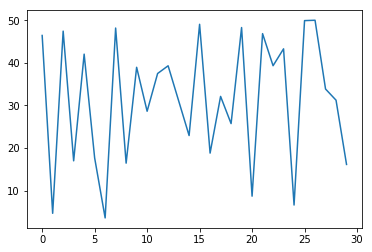

P equivalence: True
P_dist equivalence: True



Real Proba Case 2


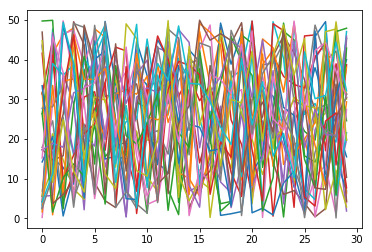

P equivalence: True
P_dist equivalence: True


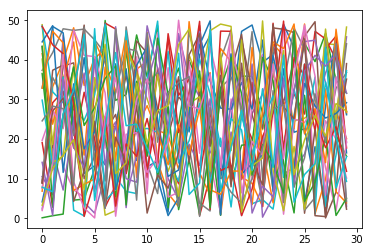

P equivalence: True
P_dist equivalence: True


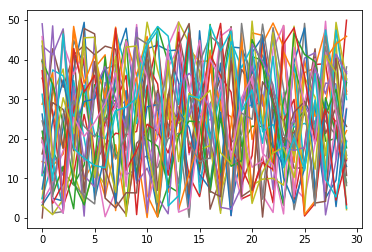

P equivalence: True
P_dist equivalence: True


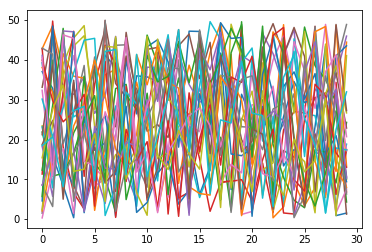

P equivalence: True
P_dist equivalence: True


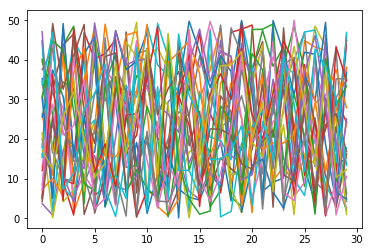

P equivalence: True
P_dist equivalence: True


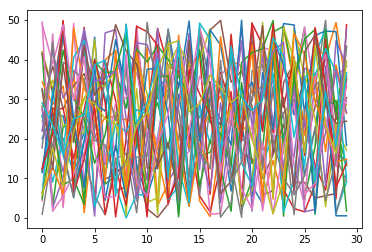

P equivalence: True
P_dist equivalence: True


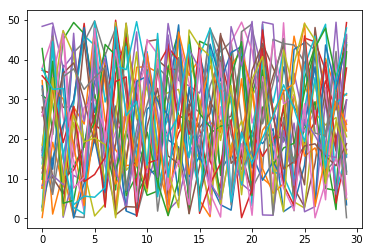

P equivalence: True
P_dist equivalence: True


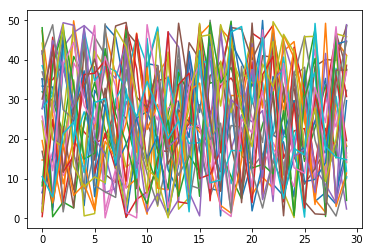

P equivalence: True
P_dist equivalence: True


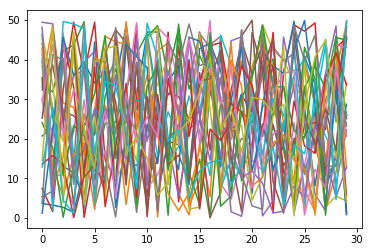

P equivalence: True
P_dist equivalence: True


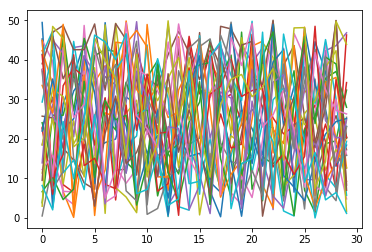

P equivalence: True
P_dist equivalence: True





In [149]:
bad_elec_probs = []
bad_dist_probs = []
for j in range(3):
    proba_case = []
    print "Real Proba Case", j
    for i in range(10):
        proba_case.append(probdata(j))
        x = range(proba_case[i][0].shape[1])
        for k in range(proba_case[i][0].shape[0]):
            plt.plot(x, proba_case[i][0][k,:])
        plt.show()
        P, P_dist = realproba(proba_case[i][0], proba_case[i][1])
        
        # Modify string for MATLAB processing
        test_split = str(proba_case[i][0]).split()
        for k in range(len(test_split)):
            if test_split[k][-1:] == "]":
                test_split[k] = test_split[k] + ";"
            elif test_split[k] != "[[" and test_split[k] != "[":
                test_split[k] = test_split[k] + ","
        newstr = ' '.join(test_split)
        #print newstr
        
        mat_P, mat_P_dist = eng.realproba(
            eng.eval(newstr), float(proba_case[i][1]), stdout = out, nargout = 2)
    #     print "MATLAB Data Norm:"
    #     print out.getvalue()
        print "P equivalence:", eval_proba(P, np.array(mat_P))
        if not eval_proba(P, np.array(mat_P)):
            bad_elec_probs.append((j, i))
    #     print "Python"
    #     print P
    #     print "MATLAB"
    #     print np.array(mat_P)
    #     print "P_dist"
    #     print P_dist
    #     print "Data"
    #     print proba_case1[i][0]
        print "P_dist equivalence:", eval_proba(P_dist, mat_P_dist)
        if not eval_proba(P_dist, mat_P_dist):
            bad_dist_probs.append((j,i))
    print
    print
    print

In [153]:
print bad_elec_probs
print bad_dist_probs
print "HOORAY!"

[]
[]
HOORAY!


***
### To check jointprob and pop_jointprob

**For all sine waves created:** make sure number of points = 1000 sampled from each wave representing data.

***Success:***
- 50 sine waves, all same frequency but different amplitudes
    - Should result in none selected
- 50 sine waves, different frequency all same amplitudes
    - Should result in none selected
- 50 sine waves, all same frequency but different amplitudes, 1 with lots of white noise
    - Should result in white noise one selected
- 50 sine waves, all different frequency but same amplitudes, 1 with lots of white noise
    - Should result in white noise one selected
- 50 sine waves, all same frequency but different amplitudes, 6-7 with white noise
    - Should result in white noise one selected

***Hopeful:***
- 40 sine waves, 32 with slight noise, 8 with heavy noise **CLOSEST TO REAL DATA**

***Fail:***
- 50 sine waves, all same frequency but different amplitudes, 40 with white noise
    - No idea result; either none selected or multiple


In [164]:
# Then define the general sine wave used throughout
def get_sin(size, tovary = 0):
    numvals = 1000
    # First, build the relevant linspace to grab 1000 points
    times = np.linspace(0, 1, numvals)
    wave = np.zeros((size, numvals))
    if tovary == 0:
        for i in range(size):
            wave[i,:] = np.random.uniform(.1, 6) * np.sin(2 * np.pi * times)
    elif tovary == 1:
        for i in range(size):
            wave[i,:] = np.sin(np.random.uniform(.1, 6) * 2 * np.pi * times)
    else:
        for i in range(size):
            wave[i,:] = np.random.uniform(.1, 6) * np.sin(np.random.uniform(.1, 6) * 2 * np.pi * times)
    return wave

# Define function for white noise
def gen_whitenoise(mean, std, size):
    retval = np.random.normal(mean, std, size=size)
    return retval

# Success Case 1 Data
# 50 sine waves, all same frequency but different amplitudes
def success1():
    return get_sin(50, 0), []

# Success Case 2 Data
# 50 sine waves, different frequency all same amplitudes
def success2():
    return get_sin(50, 1), []

# Success Case 3 Data
# 50 sine waves, all same frequency but different amplitudes, 1 with white noise
def success3():
    wn = gen_whitenoise(0, 2, 1000)
    badelec = np.floor(np.random.uniform(0, 50))
    toret = get_sin(50, 0)
    toret[badelec, :] = toret[badelec, :] + wn.T
    return toret, [badelec]
#print success2[0]

# # Success Case 3 Data
# # 50 different amplitude sine waves, 1 with white noise
# success3 = np.column_stack([sin] * 10 +
#                            [sin * 2] * 10 +
#                            [sin * 3] * 10 +
#                            [sin * 4] * 10 +
#                            [sin * 5] * 10)
# success3[:, 49] = success3[:, 49] + wn.T

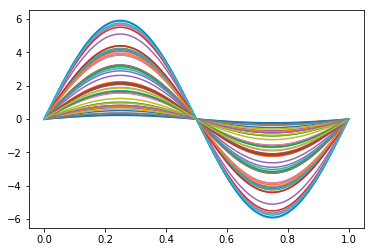

In [167]:
test_dat = success1()
for i in range(50):
    plt.plot(np.linspace(0,1,1000),test_dat[0][i,:])
plt.show()
# for i in range(50):
#     plt.plot(np.linspace(0,1,1000),success2()[0][i,:])
# plt.show()
# for i in range(50):
#     plt.plot(np.linspace(0,1,1000),success3()[0][i,:])
# plt.show()

In [175]:
print jointprob(test_dat[0], 3, 1)[0]

[]


In [192]:
out = StringIO.StringIO()
a, b = eng.jointprob(str(test_dat[0]), 3, str(), 1, nargout = 2, stdout = out)
print a
print b
print out.getvalue()

nan
False
     1

swag
        1000

[[  0.00000000e+00   1.39811536e-03   2.79617541e-03 ...,  -2.79617541e-03
   -1.39811536e-03  -5.44467971e-17]
 [  0.00000000e+00   2.19591519e-03   4.39174352e-03 ...,  -4.39174352e-03
   -2.19591519e-03  -8.55155107e-17]
 [  0.00000000e+00   2.62869244e-02   5.25728089e-02 ...,  -5.25728089e-02
   -2.62869244e-02  -1.02369152e-15]
 ..., 
 [  0.00000000e+00   2.03669413e-02   4.07330769e-02 ...,  -4.07330769e-02
   -2.03669413e-02  -7.93149660e-16]
 [  0.00000000e+00   1.17567263e-02   2.35129876e-02 ...,  -2.35129876e-02
   -1.17567263e-02  -4.57842115e-16]
 [  0.00000000e+00   3.62350531e-02   7.24686729e-02 ...,  -7.24686729e-02
   -3.62350531e-02  -1.41110143e-15]]
  Columns 1 through 6

         890         890         242         242         418         396

  Columns 7 through 12

         418         418         418         418         418         418

  Columns 13 through 18

         418         418        1000         363         418   